# SET UP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from os import listdir
from os.path import isfile, join
import random
import shutil
from matplotlib.image import imread

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import time
import seaborn as sns

# import DCGAN as gan

import json

# 1. Overview of the data

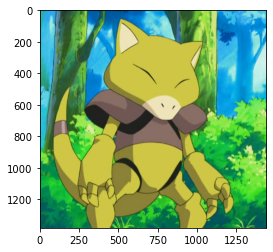

In [2]:
test_path = 'PokemonData/Abra/4e554e4a0f624656a7b1542b679b6157.jpg'
plt.imshow(imread(test_path))

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [4]:
IMG_DIR = './PokemonData'
dirs = os.listdir(IMG_DIR)
print(dirs[:10])

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise']


# 2. Data Extractor

Sample some data from the dataset and apply train, test and validation split on them.

While doing the training, we pick 10% of the image from the whole image set. Then for this small version of the data set, we use 70% to train the model, 20% images for testing and 10% for validation. 

In [5]:
def files_info_extractor(path):
    dir_list = os.listdir(path)
    y = []
    X = []
    for i in range(len(dir_list)):
        files = os.listdir(os.path.join(path,dir_list[i]))
        for j in range(len(files)):
            X.append([files[j],dir_list[i]])
    return X

Total_CLASS_NUMBER = 150
x = files_info_extractor(IMG_DIR)
X = pd.DataFrame(x,columns=["file","label"])
X.sample(10)

,file,label
5604,161c1fbcd64e404eac9614b7ed7f831a.jpg,Snorlax
1703,4f73c6a54a87426187263602fe3b6873.jpg,Gengar
4798,a48c6ded2a924f0a9597d2b74759b6a5.jpg,Porygon
2864,658fd8bb8e3d4a4bb31b4444f76e370b.jpg,Kingler
6389,f570789889b648dd836d3e04fde37238.jpg,Vileplume
6417,77950e74ed5745dba03597a26659bab5.jpg,Voltorb
1761,ba3b7ca486ec44e891a26d8789c76626.jpg,Geodude
4996,db02befbc0b24847a4557fc927306518.jpg,Rapidash
289,bf9c95ffa8e84eec80b1a09407c8b47e.jpg,Beedrill
647,c26d1fc9fe1c4ab787c426b0e0baa357.jpg,Charmeleon


In [6]:
def create_train_val_test_folder():
    os.system("mkdir train")
    os.system("mkdir test")
    os.system("mkdir val")
    
def clean_images():
    os.system("rm -r train/* test/* val/*")
    os.system("find train/ -name '*.*' -type f -delete")
    os.system("find val/ -name '*.*' -type f -delete")
    os.system("find test/ -name '*.*' -type f -delete")

def data_extractor(class_pct, train_pct, val_pct, test_pct):
    sub_classes = random.sample(dirs,int(len(dirs)*class_pct))

    for cla in sub_classes:
        os.system('mkdir "train/'+cla+'"')
        os.system('mkdir "test/'+cla+'"')
        os.system('mkdir "val/'+cla+'"')
        os.system("find train/"+cla+" -name '*.*' -type f -delete")
        os.system("find val/"+cla+" -name '*.*' -type f -delete")
        os.system("find test/"+cla+" -name '*.*' -type f -delete")

        temp_files = os.listdir(os.path.join(IMG_DIR,cla))

        files = [f for f in temp_files if isfile(os.path.join(IMG_DIR, cla,f))]
        
        train_files = random.sample(files,int(len(files)*(train_pct+val_pct+test_pct)))
        val_files = random.sample(train_files,int(len(files)*(val_pct+test_pct)))
        test_files = random.sample(val_files,int(len(files)*test_pct))
        train_files = [x for x in train_files if x not in val_files]
        val_files = [x for x in val_files if x not in test_files]
        
        for file in train_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('train',cla,file))
        for file in val_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('val',cla,file))
        for file in test_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('test',cla,file))

In [7]:
SampleSize= 0.2
TrainSize = 0.7
TestSize = 0.2
ValSize= 0.1

ClassNum = int(150 * SampleSize)

In [8]:
'''create_train_val_test_folder()

data_extractor(SampleSize, TrainSize, ValSize, TestSize)

print("Number of Classes for training is %d." % ClassNum)'''

'create_train_val_test_folder()\n\ndata_extractor(SampleSize, TrainSize, ValSize, TestSize)\n\nprint("Number of Classes for training is %d." % ClassNum)'

# 3. Data Prepareation

In [9]:
image_shape = (256,256,3)
def imageDataGenerator():
    datagen = ImageDataGenerator(rotation_range=20,
                               rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

    train = datagen.flow_from_directory('train/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=15,
                                                class_mode='categorical')
    test = datagen.flow_from_directory('test/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=15,
                                                class_mode='categorical')
    val = datagen.flow_from_directory('val/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=15,
                                                class_mode='categorical')
    return train, test, val
train, test, val = imageDataGenerator()

Found 1053 images belonging to 30 classes.
Found 287 images belonging to 30 classes.
Found 549 images belonging to 30 classes.


# 4. Build the CNN model

- Base model
- lower Learnning rate
- Learning rate deacy
- Learning rate reduction
- Dropout
- Data argumentation
- GAN

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Lambda
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [11]:
EPOCH = 100

## Baseline model
The baseline model is a model with 5 conv layers (filter size 3 x 3), 5 maxpooling layers and 3 fully connected layers.

In [12]:
def build_baseline():
    model = Sequential()

    model.add(Conv2D(filters=16,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(64,activation='relu'))

    model.add(Dense(16,activation='relu'))

    model.add(Dense(ClassNum,activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

In [14]:
baseline_model = build_baseline()
history = baseline_model.fit(train, epochs=EPOCH, validation_data=val, verbose=1)

Epoch 1/100
71/71 [==============================] - 32s 448ms/step - loss: 3.4056 - accuracy: 0.0380 - val_loss: 3.3602 - val_accuracy: 0.0364
Epoch 2/100
26/71 [=========>....................] - ETA: 13s - loss: 3.3610 - accuracy: 0.0450

KeyboardInterrupt: 

5/5 [==============================] - 1s 245ms/step - loss: 0.9684 - accuracy: 0.8065


<AxesSubplot:>

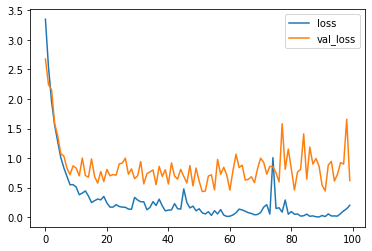

In [ ]:
loss_history = pd.DataFrame(history.history)

baseline_model.save('baseline_model.h5')
baseline_model.evaluate(test)

loss_history[['loss','val_loss']].plot()

<AxesSubplot:>

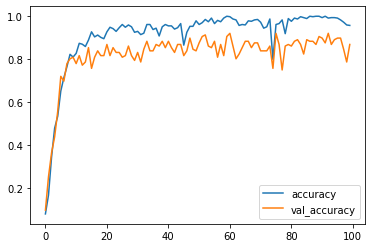

In [ ]:
loss_history[['accuracy','val_accuracy']].plot()

### Lower Learning rate

We can see that both of the training accuracy and the test accuracy is not stable, so we decide to recude the learning rate to our model.

In [ ]:
def build_baseline_lowlr():
    model = Sequential()

    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(256,activation='relu'))

    model.add(Dense(128,activation='relu'))

    model.add(Dense(ClassNum,activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

In [ ]:
baseline_lowlr_model = build_baseline_lowlr()
lowlr_history = baseline_lowlr_model.fit(train, epochs=EPOCH, validation_data=val, verbose=0)

5/5 [==============================] - 1s 169ms/step - loss: 1.6912 - accuracy: 0.7419


<AxesSubplot:>

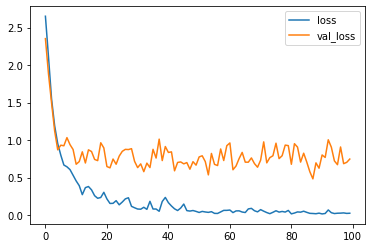

In [ ]:
loss_lowlr_history = pd.DataFrame(lowlr_history.history)

baseline_lowlr_model.save('lowlr.h5')
baseline_lowlr_model.evaluate(test)

loss_lowlr_history[['loss','val_loss']].plot()

<AxesSubplot:>

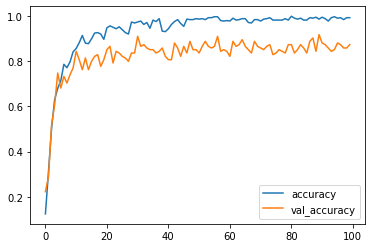

In [ ]:
loss_lowlr_history[['accuracy','val_accuracy']].plot()

## Learning rate Deacy

We can again see that both of the training accuracy and the test accuracy is not stable, so we decide to apply the learning rate deacy to our model.

In [ ]:
initial_rate = 0.001
decay_step = 15
decay_rate = 0.96

def build_baseline_Deacy():
    model = Sequential()

    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(256,activation='relu'))

    model.add(Dense(128,activation='relu'))

    model.add(Dense(ClassNum,activation='softmax'))

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_rate,
    decay_steps=decay_step,
    decay_rate=decay_rate,
    staircase=True)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_schedule), metrics=['accuracy'])

    return model

In [ ]:
Deacy_model = build_baseline_Deacy()
Deacy_history = Deacy_model.fit(train, epochs=EPOCH, validation_data=val, verbose=0)

5/5 [==============================] - 1s 180ms/step - loss: 0.9415 - accuracy: 0.8065


<AxesSubplot:>

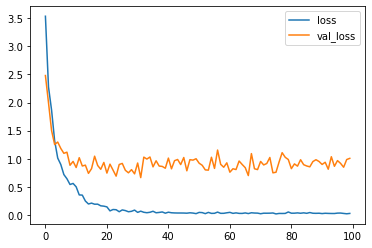

In [ ]:
loss_deacy_history = pd.DataFrame(Deacy_history.history)

Deacy_model.save('Deacy.h5')
Deacy_model.evaluate(test)

loss_deacy_history[['loss','val_loss']].plot()

<AxesSubplot:>

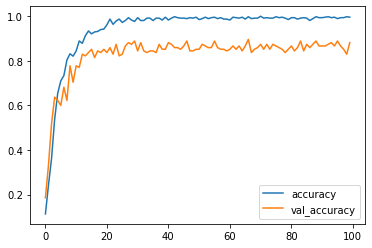

In [ ]:
loss_deacy_history[['accuracy','val_accuracy']].plot()

# Learning Rate Reduction

In [ ]:
def ReductModel():
    model = Sequential()

    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(256,activation='relu'))

    model.add(Dense(128,activation='relu'))

    model.add(Dense(ClassNum,activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

In [ ]:
Reduct_Model =ReductModel()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.0001, mode = 'auto', min_delta=0.0001, cooldown=0)

Reduct_history = Reduct_Model.fit(train, epochs=EPOCH, validation_data=val, verbose=0,  callbacks=[reduce_lr])


5/5 [==============================] - 1s 211ms/step - loss: 0.8180 - accuracy: 0.8226


<AxesSubplot:>

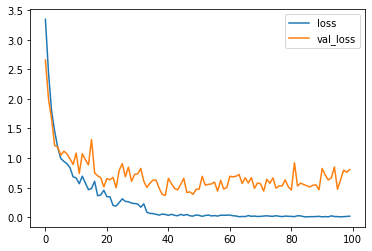

In [ ]:
loss_reduct_history = pd.DataFrame(Reduct_history.history)

Reduct_Model.save('reduct.h5')
Reduct_Model.evaluate(test)

loss_reduct_history[['loss','val_loss']].plot()

<AxesSubplot:>

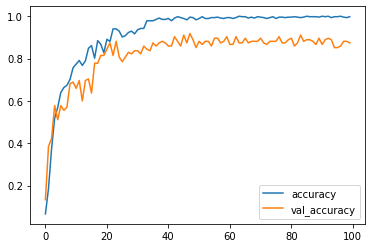

In [ ]:
loss_reduct_history[['accuracy','val_accuracy']].plot()

## Dropout

In [ ]:
def DropoutModel():
    model = Sequential()

    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(rate=0.25))

    model.add(Dense(ClassNum,activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

In [ ]:
Dropout_model = DropoutModel()
Dropout_history = Dropout_model.fit(train, epochs=EPOCH, validation_data=val, verbose=0)

4/4 [==============================] - 1s 351ms/step - loss: 0.9770 - accuracy: 0.7500


<AxesSubplot:>

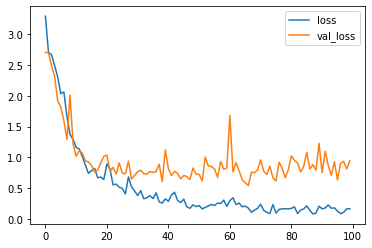

In [ ]:
loss_dropout_history = pd.DataFrame(Dropout_history.history)

Dropout_model.save('Dropout.h5')
Dropout_model.evaluate(test)

loss_dropout_history[['loss','val_loss']].plot()

<AxesSubplot:>

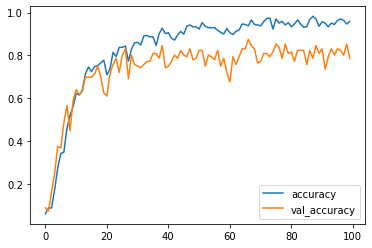

In [ ]:
loss_dropout_history[['accuracy','val_accuracy']].plot()

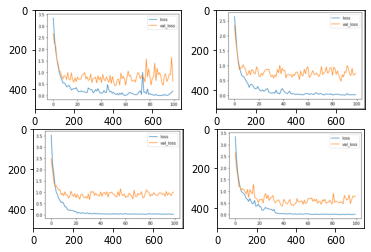

<Figure size 800x600 with 0 Axes>

In [19]:
# Loss Plot

img0 = plt.imread('./Plot/loss/baseline.png')
img1 = plt.imread('./Plot/loss/lowlr.png')
img2 = plt.imread('./Plot/loss/decay.png')
img3 = plt.imread('./Plot/loss/reduction.png')

f, axarr = plt.subplots(2,2)
plt.figure(figsize=(8, 6), dpi = 100)
axarr[0,0].imshow(img0)
axarr[0,1].imshow(img1)
axarr[1,0].imshow(img2)
axarr[1,1].imshow(img3)

plt.show()

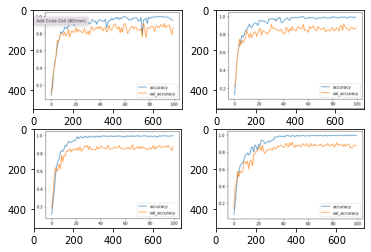

<Figure size 864x864 with 0 Axes>

In [24]:
# Acc Plot

# Loss Plot

img0 = plt.imread('./Plot/acc/baseline.png')
img1 = plt.imread('./Plot/acc/lowlr.png')
img2 = plt.imread('./Plot/acc/decay.png')
img3 = plt.imread('./Plot/acc/reduction.png')
img4 = plt.imread('./Plot/acc/Dropout.png')
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img0)
axarr[0,1].imshow(img1)
axarr[1,0].imshow(img2)
axarr[1,1].imshow(img3)

plt.figure(figsize=(12, 12))
plt.show()

## Data Augmation

In [9]:
from keras.preprocessing.image import ImageDataGenerator

baselineDataGen = ImageDataGenerator()
rotateDataGen = ImageDataGenerator(rotation_range=40)
rescaleDataGen = ImageDataGenerator(rescale = 1./255)
zcaDataGen = ImageDataGenerator(zca_whitening=True)
zoomDataGen = ImageDataGenerator(zoom_range=0.5)
allDataGen = ImageDataGenerator(rotation_range=20,
                               rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               vertical_flip = True,
                               fill_mode='nearest')

'''plt.imshow(baselineDataGen.random_transform(imread(test_path)))
plt.imshow(rotateDataGen.random_transform(imread(test_path)))
plt.imshow(rescaleDataGen.random_transform(imread(test_path)))
plt.imshow(zcaDataGen.random_transform(imread(test_path)))
plt.imshow(zoomDataGen.random_transform(imread(test_path)))
plt.imshow(allDataGen.random_transform(imread(test_path)))'''

D:\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


'plt.imshow(baselineDataGen.random_transform(imread(test_path)))\nplt.imshow(rotateDataGen.random_transform(imread(test_path)))\nplt.imshow(rescaleDataGen.random_transform(imread(test_path)))\nplt.imshow(zcaDataGen.random_transform(imread(test_path)))\nplt.imshow(zoomDataGen.random_transform(imread(test_path)))\nplt.imshow(allDataGen.random_transform(imread(test_path)))'

In [10]:
def build_baseline():
    model = Sequential()

    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(256,activation='relu'))

    model.add(Dense(128,activation='relu'))

    model.add(Dense(ClassNum,activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

In [11]:
image_shape = (256,256,3)

def generateDataFromDirectory(dg):
    train = dg.flow_from_directory('train/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=15,
                                                class_mode='categorical')
    test = dg.flow_from_directory('test/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=15,
                                                class_mode='categorical')
    val = dg.flow_from_directory('val/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=15,
                                                class_mode='categorical')
    return train, test, val

def compared_generators(gens,labels):
    historys = []
    for i in range(len(gens)):
        gen = gens[i]
        label = labels[i]
        train, test, val = generateDataFromDirectory(gen)
        model = build_baseline()
        history = model.fit(train, epochs=100, validation_data=val)
        historys.append(history)
        loss_history = pd.DataFrame(history.history)
        plt.plot(loss_history['val_accuracy'],label=label)
    plt.legend()
    #plt.savefig("./plots/compared_generators_"+time.strftime("%Y%m%d-%H%M%S")+".png")
    plt.savefig("./plots/compared_generators.png")
    plt.show()
    return historys

In [ ]:
gens = [baselineDataGen, rescaleDataGen, rotateDataGen, zcaDataGen, allDataGen]
labels = ["baseline","rescale","rotate","zca","all"]
generators_historys = compared_generators(gens,labels)
json.dump(generators_historys[0].history,open("./historys/compared_generators_default",'w'))
json.dump(generators_historys[1].history,open("./historys/compared_generators_rescale",'w'))
json.dump(generators_historys[2].history,open("./historys/compared_generators_rotate",'w'))
json.dump(generators_historys[3].history,open("./historys/compared_generators_zca",'w'))
json.dump(generators_historys[4].history,open("./historys/compared_generators_all",'w'))

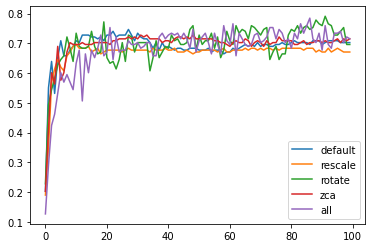

In [25]:
default_history = json.load(open("./historys/compared_generators_default",'r'))
rescale_history = json.load(open("./historys/compared_generators_rescale","r"))
rotate_history = json.load(open("./historys/compared_generators_rotate","r"))
zca_history = json.load(open("./historys/compared_generators_zca","r"))
all_history = json.load(open("./historys/compared_generators_all","r"))
plt.plot(default_history["val_accuracy"],label="default")
plt.plot(rescale_history["val_accuracy"],label="rescale")
plt.plot(rotate_history["val_accuracy"],label="rotate")
plt.plot(zca_history["val_accuracy"],label="zca")
plt.plot(all_history["val_accuracy"],label="all")
plt.legend()
plt.show()

## GAN

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from os import listdir
from os.path import isfile, join
import random
import shutil
from matplotlib.image import imread
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from tensorflow.keras.utils import Sequence
import time
import seaborn as sns
import DCGAN as gan
import json

In [13]:
def files_info_extractor(path):
    dir_list = os.listdir(path)
    y = []
    X = []
    for i in range(len(dir_list)):
        files = os.listdir(os.path.join(path,dir_list[i]))
        for j in range(len(files)):
            X.append([files[j],dir_list[i]])
    return X

In [14]:
IMG_DIR = './PokemonData'
x = files_info_extractor(IMG_DIR)
X = pd.DataFrame(x,columns=["file","label"])

In [15]:
class_names = X["label"].unique()
max_num = X["label"].value_counts()

In [16]:
image_shape = (256,256,3)

def data_extractor_gan(classes,train_pct, val_pct, test_pct):
    for cla in classes:
        os.system('mkdir "train/'+cla+'"')
        os.system('mkdir "test/'+cla+'"')
        os.system('mkdir "val/'+cla+'"')
        os.system("find train/"+cla+" -name '*.*' -type f -delete")
        os.system("find val/"+cla+" -name '*.*' -type f -delete")
        os.system("find test/"+cla+" -name '*.*' -type f -delete")
        os.system('mkdir "include_gan"')
        os.system('mkdir "include_gan/train/'+cla+'"')
        os.system('mkdir "include_gan/test/'+cla+'"')
        os.system('mkdir "include_gan/val/'+cla+'"')
        os.system("find include_gan/train/"+cla+" -name '*.*' -type f -delete")
        os.system("find include_gan/val/"+cla+" -name '*.*' -type f -delete")
        os.system("find include_gan/test/"+cla+" -name '*.*' -type f -delete")

        temp_files = os.listdir(os.path.join(IMG_DIR,cla))
        files = [f for f in temp_files if isfile(os.path.join(IMG_DIR, cla,f))]
        train_files = random.sample(files,int(len(files)*(train_pct+val_pct+test_pct)))
        val_files = random.sample(train_files,int(len(files)*(val_pct+test_pct)))
        test_files = random.sample(val_files,int(len(files)*test_pct))
        train_files = [x for x in train_files if x not in val_files]
        val_files = [x for x in val_files if x not in test_files]
        
        for file in train_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('include_gan','train',cla,file))
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('train',cla,file))
        for file in val_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('include_gan','val',cla,file))
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('val',cla,file))
        for file in test_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('include_gan','test',cla,file))
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('test',cla,file))
        temp_files = os.listdir(os.path.join("savedData",cla))
        files = [f for f in temp_files if isfile(os.path.join("savedData", cla,f))]
        for file in files:
            shutil.copy(os.path.join("savedData",cla,file), os.path.join("include_gan",'train',cla,file))


In [19]:
data_extractor_gan(class_names[:20],0.7,0.2,0.1)

In [18]:
def generateDataFromDirectory(dg):
    train = dg.flow_from_directory('train/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=15,
                                                class_mode='categorical')
    test = dg.flow_from_directory('test/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=15,
                                                class_mode='categorical')
    val = dg.flow_from_directory('val/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=15,
                                                class_mode='categorical')
    return train, test, val


def generateDataFromDirectory_gan(dg):
    train = dg.flow_from_directory('include_gan/train/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=15,
                                                class_mode='categorical')
    test = dg.flow_from_directory('include_gan/test/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=15,
                                                class_mode='categorical')
    val = dg.flow_from_directory('include_gan/val/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=15,
                                                class_mode='categorical')
    return train, test, val

def compared_with_without_gan():
    historys = []
    train, test, val = generateDataFromDirectory(allDataGen)
    gan_train, gan_test, gan_val = generateDataFromDirectory_gan(allDataGen)
    model = build_baseline()
    gan_model = build_baseline()
    history = model.fit(train, epochs=100, validation_data=val, batch_size= 256)
    gan_history = gan_model.fit(gan_train, epochs=100,validation_data=gan_val, batch_size= 256)
    historys.append(history)
    historys.append(gan_history)
    loss_history = pd.DataFrame(history.history)
    gan_loss_history = pd.DataFrame(gan_history.history)
    plt.plot(loss_history['val_accuracy'],label="original")
    plt.plot(gan_loss_history['val_accuracy'],label="gan")
    plt.legend()
    plt.savefig("./plots/compared_with_without_gan.png")
    plt.show()
    return historys

In [21]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
gan_historys = compared_with_without_gan()

Found 1053 images belonging to 30 classes.
Found 287 images belonging to 30 classes.
Found 549 images belonging to 30 classes.
Found 2114 images belonging to 30 classes.
Found 230 images belonging to 30 classes.
Found 472 images belonging to 30 classes.
Epoch 1/100
71/71 [==============================] - 43s 501ms/step - loss: 3.3633 - accuracy: 0.0779 - val_loss: 2.9451 - val_accuracy: 0.1530
Epoch 2/100
71/71 [==============================] - 30s 424ms/step - loss: 2.7872 - accuracy: 0.1538 - val_loss: 2.4963 - val_accuracy: 0.2040
Epoch 3/100
71/71 [==============================] - 27s 386ms/step - loss: 2.3304 - accuracy: 0.2640 - val_loss: 1.8708 - val_accuracy: 0.4262
Epoch 4/100
71/71 [==============================] - 27s 385ms/step - loss: 1.8671 - accuracy: 0.3903 - val_loss: 1.4826 - val_accuracy: 0.4882
Epoch 5/100
34/71 [=============>................] - ETA: 9s - loss: 1.6709 - accuracy: 0.4378 

KeyboardInterrupt: 

In [ ]:
json.dump(gan_historys[0].history,open("./historys/compared_generators_original",'w'))
json.dump(gan_historys[1].history,open("./historys/compared_generators_gan",'w'))

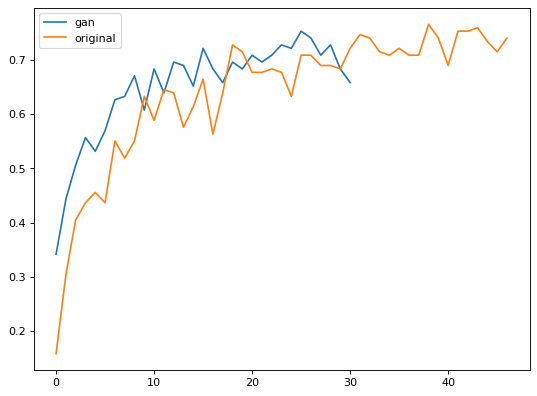

In [26]:
gan_history = json.load(open("./historys/compared_dataset_gan",'r'))
original_history = json.load(open("./historys/compared_dataset_original","r"))
plt.figure(figsize=(8,6),dpi=80)
plt.plot(gan_history["val_accuracy"],label="gan")
plt.plot(original_history["val_accuracy"],label="original")
plt.legend()
plt.show()